# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 7: $k$-NN Classification, Missingness, and PCA

**Harvard University**<br>
**Summer 2021**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner, Kevin Rader

---

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> $k$-NN Classification </li> 
<li> PCA </li>
<li> Multiclass Classification Models </li> 

    

## Learning Goals

This Jupyter notebook accompanies Lecture 7. By the end of this lecture, you should be able to:

- Fit, plot, and 'interpret' $k$-NN classification models
- Determine classification boundaries (through plotting predictions) for $k$-NN models
- Perform principal components analysis (PCA) on a set of predictors
- Use the PCA vectors as the basis of modeling and visualizations
- Be comfortable with multiclass models


In [1]:
%matplotlib inline
import sys
import numpy as np
import pylab as pl
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.decomposition import PCA
import sklearn.metrics as met

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

## Part 0: Reading the data 

In this notebook, we will be using the same Heart dataset from last lecture.  As a reminder the variables we will be using today include:

- `AHD`: whether or not the patient presents atherosclerotic heart disease (a heart attack): `Yes` or `No`
- `Sex`: a binary indicator for whether the patient is male (Sex=1) or female (Sex=0)
- `Age`: age of patient, in years
- `MaxHR`: the maximum heart rate of patient based on exercise testing
- `RestBP`: the resting systolic blood pressure of the patient
- `Chol`: the HDL cholesterol level of the patient

For further information on the dataset, please see the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

In [2]:
df_heart = pd.read_csv('../data/Heart.csv')

# Force the response into a binary indicator:
df_heart['AHD'] = 1*(df_heart['AHD'] == "Yes")

print(df_heart.shape)
df_heart.head()

(303, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,0
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,1
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,1
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,0
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,0


Here are some basic summaries and EDA from last time:

In [3]:
df_heart.describe()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,303.000000
mean,152.000000,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,0.458746
std,87.612784,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,0.499120
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,76.500000,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,152.000000,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,227.500000,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,1.000000
max,303.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


In [4]:
pd.crosstab(df_heart['Sex'],df_heart['AHD'])


AHD,0,1
Sex,,
0,72,25
1,92,114


In [5]:
pd.crosstab(df_heart['Thal'],df_heart['AHD'])


AHD,0,1
Thal,,
fixed,6,12
normal,129,37
reversable,28,89


In [6]:
pd.crosstab(df_heart['ChestPain'],df_heart['AHD'])


AHD,0,1
ChestPain,,
asymptomatic,39,105
nonanginal,68,18
nontypical,41,9
typical,16,7


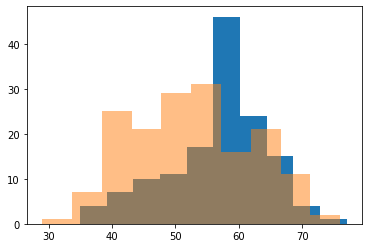

In [7]:
plt.hist(df_heart['Age'][df_heart['AHD']==1])
plt.hist(df_heart['Age'][df_heart['AHD']==0],alpha=0.5)
plt.show()

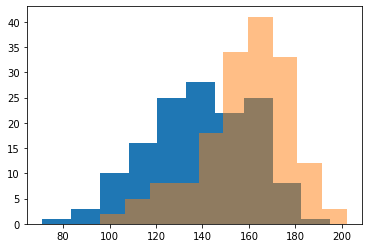

In [8]:
plt.hist(df_heart['MaxHR'][df_heart['AHD']==1])
plt.hist(df_heart['MaxHR'][df_heart['AHD']==0],alpha=0.5)
plt.show()

---

## Part 1: $k$-NN Classification

Several [*k*-nn classification models](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) using sklearn are fit and plotted below, using `MaxHR` as the sole predictor:

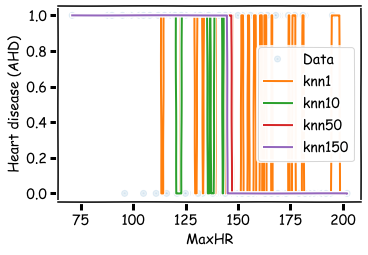

In [9]:
data_x = df_heart[['MaxHR']]
data_y = df_heart['AHD']

knn1 = KNeighborsClassifier(n_neighbors=1)
knn10 = KNeighborsClassifier(n_neighbors=10)
knn50 = KNeighborsClassifier(n_neighbors=50)
knn150 = KNeighborsClassifier(n_neighbors=150)

knn1.fit(data_x, data_y);
knn10.fit(data_x, data_y);
knn50.fit(data_x, data_y);
knn150.fit(data_x, data_y);


fig = plt.figure()
fig.patch.set_alpha(0.0)
plt.xkcd(scale=0.1, length=0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.16, right=0.86)


x=np.linspace(np.min(data_x),np.max(data_x),500)
yhat1 = knn1.predict(x)
yhat10 = knn10.predict(x)
yhat50 = knn50.predict(x)
yhat150 = knn150.predict(x)

plt.plot(data_x, data_y, 'o' ,alpha=0.1, label='Data')
plt.plot(x,yhat1, label='knn1')
plt.plot(x,yhat10, label='knn10')
plt.plot(x,yhat50, label='knn50')
plt.plot(x,yhat150, label='knn150')

plt.legend()

plt.xlabel("MaxHR")
plt.ylabel("Heart disease (AHD)")

plt.show()


**Q1.1** Interpret these results: what is this plot showing?  How useful is it?  What would be a better plot to visualize the predictions?

*your asnwer here*

**Q1.2** Create a similar plot as above, but instead use the predicted probabilities of success.  Interpret this plot: which model seems to be most appropriate?

In [ ]:
######
# your code here
######



$k$-NN classification can also be applied to multiple predictors at once:

In [ ]:
#two predictors

data_x = df_heart[['MaxHR','Age']]

knn1.fit(data_x, data_y);
knn10.fit(data_x, data_y);
knn50.fit(data_x, data_y);
knn150.fit(data_x, data_y);

print(knn1.score(data_x, data_y))
print(knn10.score(data_x, data_y))
print(knn50.score(data_x, data_y))
print(knn150.score(data_x, data_y))

**Q1.3** Which predictor has more influence on the model above?  How could we fix this 'issue'?  Refit knn10 with the issue resolved (call it `knn10_fixed`).

*your answer here* 



In [ ]:
from sklearn.preprocessing import StandardScaler

######
# your code here
######



In order to plot prediction on 2-D predictor space, some work needs to be done (several ways to do this).  This is done for you 

In [ ]:
n = 100

x1=np.linspace(np.min(df_heart[['MaxHR']]),np.max(df_heart[['MaxHR']]),n)
x2=np.linspace(np.min(df_heart[['Age']]),np.max(df_heart[['Age']]),n)
x1v, x2v = np.meshgrid(x1, x2)

# This is how we would typically do the prediction (have a vector of yhats)
#yhat10 = knn10.predict(np.array([x1v.flatten(),x2v.flatten()]).reshape(-1,2))

# To do the predictions and keep the yhats on 2-D (to match the dummy predictor shapes), use this
yhat50 = knn50.predict_proba(np.c_[x1v.ravel(), x2v.ravel()])[:,1]



In [ ]:
#plt.scatter(x1v.flatten(),x2v.flatten(),c=yhat10)
plt.pcolormesh(x1v, x2v, yhat50.reshape(x1v.shape)) #, cmap=cmap_light
plt.show()

In [ ]:
#plt.scatter(x1v.flatten(),x2v.flatten(),c=yhat10)
yhat50 = knn50.predict(np.c_[x1v.ravel(), x2v.ravel()])
plt.pcolormesh(x1v, x2v, yhat50.reshape(x1v.shape)) #, cmap=cmap_light
plt.show()

**Q1.4** Recreate the plot above using `knn10_fixed`.  What differences do you notice?  How do these plots compare to what plot would look like from a logistic regression model?

Hint: make sure you reapply your scaler on the X matrix when doing the predictions.

In [ ]:
######
# your code here
######



It has a slightly different picture, but the same general pattern.  Note the logistic regression model (without interactions) would be a straight line.  See below.

In [ ]:
logit = LogisticRegression(C=10000).fit(df_heart[['MaxHR','Age']], df_heart['AHD'])
phat_logit = logit.predict_proba(np.c_[x1v.ravel(), x2v.ravel()])[:,1]
yhat_logit = logit.predict(np.c_[x1v.ravel(), x2v.ravel()])

plt.pcolormesh(x1v, x2v, yhat_logit.reshape(x1v.shape)) 
plt.show()

In [ ]:
# Don't forget to split into train and test  (or better yet, use cross-validation) 
# generally speaking to evaluate model performance or to determine what k is actually best!

---

## Part 2: Principal Components Analysis (PCA) 

**Q2.1** Just a sidebar (and a curiosity), what happens when two of the identical predictor is used in logistic regression?  Is an error created?  Should one be?  Investigate by predicting `AHD` from two copies of `Age`, and compare to the simple logistic regression model with `Age` alone

In [ ]:
y = df_heart['AHD']

logit1 = LogisticRegression(C=1000000,solver="lbfgs").fit(df_heart[['Age']],y)

# investigating what happens when two identical predictors are used

######
# your code here
######

logit2 = LogisticRegression(C=1000000,solver="lbfgs").fit(df_heart[['Age','Age','Age']],y)

print("The coef estimate for Age (when in the model once):",logit1.coef_)
print("The coef estimate for Age (when in the model twice):",logit2.coef_)

We will apply PCA to the heart dataset when there are just 4 predictors considered (remember: PCA is used when dimensionality is high (lots of predictors), but this will help us get our heads around what is going on):

In [ ]:
# For pedagogical purposes, let's simplify our lives and use just 4 predictors
X = df_heart[['Age','RestBP','Chol','MaxHR']]
y = df_heart['AHD']
X.describe()

First let's fit the full logistic regression model to predict `AHD` from the 4 predictors above.

Remember: PCA is an approach to handling the predictors, so it does not matter if we are using it for a regression or classification type problem.

In [ ]:
#fit the 'full' model on the 4 predictors. and print out the coefficients
logit_full = LogisticRegression(C=1000000,solver="lbfgs").fit(X,y)

beta = logit_full.coef_[0]

print(beta)

**Q2.2** Is there any evidence of multicollinearity in the set of predictors?  How do you know?  How will PCA handle these correlations?

*your answer here*

Next we apply the [PCA transformation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) in a few steps, and show some of the results below:

In [ ]:
# create/fit the 'full' pca transformation
pca = PCA().fit(X)

# apply the pca transformation to the full predictor set
pcaX = pca.transform(X)

# convert to a data frame
pcaX_df = pd.DataFrame(pcaX, columns=[['PCA1' , 'PCA2', 'PCA3', 'PCA4']])

# here are the weighting (eigen-vectors) of the variables (first 2 at least)
print("First PCA Component (w1):",pca.components_[0,:])
print("Second PCA Component (w2):",pca.components_[1,:])

# here is the variance explained:
print("Variance explained by each component:",pca.explained_variance_ratio_)

In [ ]:
print(pca.components_.shape)
print(pcaX.shape, X.shape)

**Q2.3** Interpret the results above.  What doss $w_1$ represent?  Why do the values make sense?  What does it's values squared sum up to?  Why does this make sense?

*your answer here*

In [ ]:
######
# your code here
######
pca.components_[0,:]

It is common for a model with high dimensional data (lots of predictors) to be plotted along the first 2 PCA components (with the classification boundaries added).  Below is the scatter plot for these data (without a classificaiton boundary, since we do not have a model yet):

In [ ]:
# Plot the response over the first 2 PCA component vectors

plt.scatter(pcaX_df[['PCA1']][y==0],pcaX_df[['PCA2']][y==0])
plt.scatter(pcaX_df[['PCA1']][y==1],pcaX_df[['PCA2']][y==1])

plt.legend(["AHD = No","AHD = Yes"])
plt.xlabel("First PCA Component Vector (Z1)")
plt.ylabel("Second PCA Component Vector (Z2)");


**Q2.4** What would a classification boundary look like if a logistic regression model were fit using the first 2 principal components as the predictors?  Does there appear to be good potential here?

*your answer here*

Below is the result of the PCR-1 (logistic) to predict `AHD` from the first principal component vector.

In [ ]:
logit_pcr1 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1']],y)

print("Intercept from simple PCR-Logistic:",logit_pcr1.intercept_)
print("'Slope' from simple PCR-Logistic:", logit_pcr1.coef_)

print("First PCA Component (w1):",pca.components_[0:1,:])


**Q2.5** What does this PCR-1 model tell us about how the predictors relate to the response (aka, estimate the coefficient(s) in the original predictor space)?  Is it truly a simple logistic regression model in the original predictor space?

In [ ]:
######
# your code here
######

*your answer here*

Here is the above claculation for all 4 PCR logistic regressions, and then plotted on a pretty plot:

In [ ]:
# Fit the other 3 PCRs on the rest of the 4 predictors

logit_pcr2 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2']],y)
logit_pcr3 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2','PCA3']],y)
logit_pcr4 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2','PCA3','PCA4']],y)

pcr1=(logit_pcr1.coef_*np.transpose(pca.components_[0:1,:])).sum(axis=1)
pcr2=(logit_pcr2.coef_*np.transpose(pca.components_[0:2,:])).sum(axis=1)
pcr3=(logit_pcr3.coef_*np.transpose(pca.components_[0:3,:])).sum(axis=1)
pcr4=(logit_pcr4.coef_*np.transpose(pca.components_[0:4,:])).sum(axis=1)

results = np.vstack((pcr1,pcr2,pcr3,pcr4,beta))
print(results)

In [ ]:
plt.plot(['PCR1' , 'PCR2', 'PCR3', 'PCR4', 'Logistic'],results)

plt.ylabel("Back-calculated Beta Coefficients");

plt.legend(X.columns);

**Q2.6** Interpret the plot above.  Specifically, compare how each PCA vector "contributes" to the original logistic regression model using all 4 original predictors.  How Does PCR-4 compare to the original logistic regression model (in estimated coefficients)?

*your answer here*

All of this PCA work should have been done using the standardized versions of the predictors.  Below is the code that does exactly that:

In [ ]:
scaler = sk.preprocessing.StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)
pca = PCA(n_components=4).fit(Z)
pcaZ = pca.transform(Z)
pcaZ_df = pd.DataFrame(pcaZ, columns=[['PCA1' , 'PCA2', 'PCA3', 'PCA4']])

print("First PCA Component (w1):",pca.components_[0,:])
print("Second PCA Component (w2):",pca.components_[1,:])

In [ ]:
# Plot the response over the first 2 PCA component vectors

plt.scatter(pcaZ_df[['PCA1']][y==0],pcaZ_df[['PCA2']][y==0])
plt.scatter(pcaZ_df[['PCA1']][y==1],pcaZ_df[['PCA2']][y==1])

plt.legend(["AHD = No","AHD = Yes"])
plt.xlabel("First PCA Component Vector (Z1) based on standardized data")
plt.ylabel("Second PCA Component Vector (Z2) based on standardized data");


In [ ]:
#fit the 'full' model on the 4 predictors. and print out the coefficients
logit_full = LogisticRegression(C=1000000,solver="lbfgs").fit(Z,y)


betaZ = logit_full.coef_[0]

print("Logistic coef. on standardized predictors:",betaZ)

In [ ]:
# Fit the PCR
logit_pcr1Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1']],y)
logit_pcr2Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1','PCA2']],y)
logit_pcr3Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1','PCA2','PCA3']],y)
logit_pcr4Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1','PCA2','PCA3','PCA4']],y)

pcr1Z=(logit_pcr1Z.coef_*np.transpose(pca.components_[0:1,:])).sum(axis=1)
pcr2Z=(logit_pcr2Z.coef_*np.transpose(pca.components_[0:2,:])).sum(axis=1)
pcr3Z=(logit_pcr3Z.coef_*np.transpose(pca.components_[0:3,:])).sum(axis=1)
pcr4Z=(logit_pcr4Z.coef_*np.transpose(pca.components_[0:4,:])).sum(axis=1)

resultsZ = np.vstack((pcr1Z,pcr2Z,pcr3Z,pcr4Z,betaZ))
print(resultsZ)

plt.plot(['PCR1-Z' , 'PCR2-Z', 'PCR3-Z', 'PCR4-Z', 'Logistic'],resultsZ)

plt.ylabel("Back-calculated Beta Coefficients");

plt.legend(X.columns);

**Q2.7** Compare this plot to the previous one; why does this plot make sense?.  What does this illustrate?  

*your answer here*

---

## Part 3: Multiclass using Irises

This problem provides code to analyze a multiclass problem: using the [R.A. Fisher's classic Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set).

In [ ]:
#read in the dataset from sklearn and explore:
from sklearn import datasets
raw = datasets.load_iris()
iris = pd.DataFrame(raw['data'],columns=raw['feature_names'])
iris['type'] = raw['target'] 

# Ideally we'd split into train and test if prediction was important...but this is just for learning purposes
# iris_train, iris_test, y_train, y_test = train_test_split(iris, test_size=0.3, random_state=109, shuffle=True)
iris.head()

In [ ]:
# Let's see how the sepal length varies across types
sns.violinplot(y=iris['sepal length (cm)'], x=iris['type'], split=True);

In [ ]:
# Let's see how the sepal width varies across types
sns.violinplot(y=iris['sepal width (cm)'], x=iris['type'], split=True);

In [ ]:
# Fitting an ovr logistic regression (unregularized) to predict type with sepal length and width
logit_ovr = LogisticRegression(penalty='none', multi_class='ovr',max_iter = 1000).fit(
    iris[['sepal length (cm)','sepal width (cm)']], iris['type'])
print(logit_ovr.intercept_)
print(logit_ovr.coef_)


**Q3.1** Interpret the coefficients.  Why are there 3 sets? 

*your answer here*

In [ ]:
# perform the predicted probability calculations
print(logit_ovr.predict_proba(iris[['sepal length (cm)','sepal width (cm)']]))

#and the predicted classes
logit_ovr.predict(iris[['sepal length (cm)','sepal width (cm)']])

In [ ]:
# and the overall classification accuracy for the ovr model:
print(logit_ovr.score(iris[['sepal length (cm)','sepal width (cm)']],iris['type']))

In [ ]:
# here's the multinomial version
logit_multi = LogisticRegression(penalty='none', multi_class='multinomial',max_iter = 1000).fit(
    iris[['sepal length (cm)','sepal width (cm)']], iris['type'])
print(logit_multi.intercept_)
print(logit_multi.coef_)

In [ ]:
# and the overall classification accuracy for the multinomial model:
print(logit_multi.score(iris[['sepal length (cm)','sepal width (cm)']],iris['type']))

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x1_range = iris['sepal length (cm)'].max() - iris['sepal length (cm)'].min()
x2_range = iris['sepal width (cm)'].max() - iris['sepal width (cm)'].min()
x1_min, x1_max = iris['sepal length (cm)'].min()-0.1*x1_range, iris['sepal length (cm)'].max() +0.1*x1_range
x2_min, x2_max = iris['sepal width (cm)'].min()-0.1*x2_range, iris['sepal width (cm)'].max() + 0.1*x2_range

step = .05 
x1x, x2x = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
y_hat_ovr = logit_ovr.predict(np.c_[x1x.ravel(), x2x.ravel()])
y_hat_multi = logit_multi.predict(np.c_[x1x.ravel(), x2x.ravel()])



fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15, 6))

ax1.pcolormesh(x1x, x2x, y_hat_ovr.reshape(x1x.shape), cmap=plt.cm.Paired,alpha = 0.5)
ax1.scatter(iris['sepal length (cm)'], iris['sepal width (cm)'], c=iris['type'], edgecolors='k', cmap=plt.cm.Paired)
ax1.set_title("OVR Logistic Regression")

ax2.pcolormesh(x1x, x2x, y_hat_multi.reshape(x1x.shape), cmap=plt.cm.Paired,alpha = 0.5)
ax2.scatter(iris['sepal length (cm)'], iris['sepal width (cm)'], c=iris['type'], edgecolors='k', cmap=plt.cm.Paired)
ax2.set_title("Multinomial Logistic Regression")

plt.show()

In [ ]:
# Fit a knn with k=5 model
knn5 = KNeighborsClassifier(5).fit(iris[['sepal length (cm)','sepal width (cm)']], iris['type'])

In [ ]:
# and the overall classification accuracy for the knn(5) model:
print(knn5.score(iris[['sepal length (cm)','sepal width (cm)']],iris['type']))

In [ ]:
## Plot the decision boundary. 

y_hat_knn5 = knn5.predict(np.c_[x1x.ravel(), x2x.ravel()])

fig, ax1 = plt.subplots(1, 1,  figsize=(8, 6))

ax1.pcolormesh(x1x, x2x, y_hat_knn5.reshape(x1x.shape), cmap=plt.cm.Paired,alpha = 0.5)
# Plot also the training points
ax1.scatter(iris['sepal length (cm)'], iris['sepal width (cm)'], c=iris['type'], edgecolors='k', cmap=plt.cm.Paired)

plt.show()

**Q3.2** How do the plots of the 3 classification boundaries compare?  Which is the best choice?

*your answer here*